# Training

In [360]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

# mpi_sintel_root = '/content/gdrive/MyDrive/AI535_Final_Project/datasets/MPISintel'
# flying_chairs_root = '/content/gdrive/MyDrive/AI535_Final_Project/datasets/FlyingChairs'
# !ls '/content/gdrive/MyDrive/AI535_Final_Project/datasets/MPISintel'
# !ls '/content/gdrive/MyDrive/AI535_Final_Project/datasets/FlyingChairs'

In [361]:
# Imports
# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# # PWCNet Data & Model (Defined by us)
# !ls '/content/gdrive/MyDrive/AI535_Final_Project/model.py'
# !ls '/content/gdrive/MyDrive/AI535_Final_Project/dataset.py'
# import sys
# sys.path.append('/content/gdrive/My Drive/AI535_Final_Project')
# from dataset import MPISintelDataset
from model import PWCNetMultiScale

import cv2

import os

In [362]:
# Hyperparameters
feature_channels = 64
max_displacement = 4
num_epochs = 30
batch_size = 2
learning_rate = 0.01 #1e-4
log_interval = 4

# Loss Function Parameters
alpha = [0.32, 0.08, 0.02, 0.01, 0.005]
epsilon = 0.001
q = 0.4

In [363]:
# Loss Function Definition
class MultiScaleEPELoss(nn.Module):
  def __init__(self, alpha, epsilon, q):
    super(MultiScaleEPELoss, self).__init__()
    self.alpha = alpha
    self.epsilon = epsilon
    self.q = q

  def forward(self, predicted_flows, ground_truth_flows):
    loss = 0.0
    for l, (pred_flow, gt_flow) in enumerate(zip(predicted_flows, ground_truth_flows)):
      # print("Layer Number: ", l)
      # Upsample predicted flow to match the size of the ground truth flow
      if pred_flow.size()[-2:] != gt_flow.size()[-2:]:
        pred_flow = F.interpolate(pred_flow, size=gt_flow.size()[-2:], mode='bilinear', align_corners=False)
        # Scale the flow values to match the upsampling
        scale_factor = gt_flow.size()[-1] / pred_flow.size()[-1]
        pred_flow *= scale_factor

      # Compute the endpoint error (EPE)
      epe = torch.norm(pred_flow - gt_flow + self.epsilon, p=self.q, dim=1)
      layer_loss = self.alpha[l] * epe.mean()
      loss += layer_loss

    return loss

In [364]:
# GPU Info + Configuration
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Selected: ', device)

Selected:  cuda


In [365]:
# Import Data
transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

class CustomTransform:
    def __init__(self, transforms):
        self.image_transform = transforms

    def __call__(self, img1, img2, flow, valid_flow_mask):
        # Apply resize to img1
        img1 = self.image_transform(img1)
        # Apply resize to img2
        img2 = self.image_transform(img2)

        flow = torch.tensor(flow)
        flow = F.interpolate(flow.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)

        return img1, img2, flow, valid_flow_mask

custom_transform = CustomTransform(transforms)



sintel_train_root = 'sintel/training/'
trainset = datasets.Sintel(root=sintel_train_root, split='train', pass_name='clean', transforms=custom_transform)
trainset = torch.utils.data.Subset(trainset, range(10))
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

sintel_test_root = 'sintel/testing/'
testset = datasets.Sintel(root=sintel_test_root, split='train', pass_name='clean', transforms=custom_transform)
testset = torch.utils.data.Subset(testset, range(70,80))
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# trainset = datasets.FlyingChairs(root='', split='train', transforms=custom_transform)
# trainset = torch.utils.data.Subset(trainset, range(10))
# trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
# testset = datasets.FlyingChairs(root='', split='val', transforms=custom_transform)
# testset = torch.utils.data.Subset(testset, range(10))
# testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
'''
testloader is left UNSHUFFLED, so that when we iterate over it for training, our dataloader entries have
indices that correspond to the original dataset. This allows us to create visualizations of flow when
evaluating on training.
'''
print('Train: ', len(trainloader), 'Test: ', len(testloader))

Train:  5 Test:  5


In [366]:
# Initialize the model
model = PWCNetMultiScale(feature_channels=feature_channels, max_displacement=max_displacement).to(device)

# Instantiate the loss function
loss_function = MultiScaleEPELoss(alpha, epsilon, q).to(device)
# print(loss_function.device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

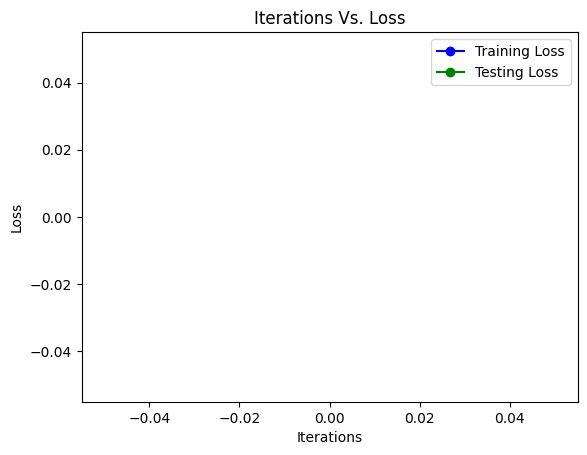

In [367]:
import csv
from datetime import datetime

timestamp = datetime.now().strftime('%y%m%d_%H%M%S')
log_filepath = f'logs/training_log_{timestamp}.csv'

csv_columns = ['Set', 'Iteration', 'Loss', 'Accuracy']
csv_file = open(log_filepath, 'w', newline='')
csv_writer = csv.DictWriter(csv_file, fieldnames=csv_columns)
csv_writer.writeheader()

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

plot_filepath = f'logs/training_log_{timestamp}.png'

# plt.ion()

fig, ax = plt.subplots()
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Iterations Vs. Loss')

plt_x_1, plt_y_1 = [], [] # Training Loss
plt_x_2, plt_y_2 = [], [] # Testing Loss

train_line, = ax.plot(plt_x_1, plt_y_1, 'bo-', label='Training Loss')
test_line, = ax.plot(plt_x_2, plt_y_2, 'go-', label='Testing Loss')
ax.legend();

In [368]:
# def endpoint_error(flow_est, flow_gt):
#     print([flow.size() for flow in flow_est], flow_gt.size())
#     return 

def save_flow_viz(flow_tensor, filename):
    # Transfer flow to visualize to CPU
    flow_gt_cpu = np.transpose(flow_tensor, (1, 2, 0))

    # Convert flow to RGB color for visualization
    h, w, _ = flow_gt_cpu.shape
    flow_viz = np.zeros((h, w, 3), dtype=np.uint8)

    # flow_viz[..., 0] = (flow_gt_cpu[...,0] + 20) * 5 # Red channel
    # flow_viz[..., 1] = (flow_gt_cpu[...,1] + 20) * 5 # Green channel

    # Compute magnitude and angle of flow vectors
    magnitude, angle = cv2.cartToPolar(flow_gt_cpu[..., 0].numpy(), flow_gt_cpu[..., 1].numpy())

    # Convert angle to degrees and normalize to [0, 360]
    angle_degrees = (angle * 180 / np.pi / 2) % 360

    # Set hue channel based on angle, saturation based on magnitude, and value to maximum
    flow_viz[..., 0] = angle_degrees
    flow_viz[..., 1] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    flow_viz[..., 2] = 255  # Maximum value

    # Convert HSV to RGB
    flow_viz_rgb = cv2.cvtColor(flow_viz, cv2.COLOR_HSV2BGR)

    cv2.imwrite(filename, flow_viz_rgb)

def save_ppm_image(image_1, image_2, file_prefix):
    image_1 = np.transpose(image_1.numpy(), (1, 2, 0))
    image_2 = np.transpose(image_2.numpy(), (1, 2, 0))

    image_1 = (image_1 * 255).astype(np.uint8)
    image_2 = (image_2 * 255).astype(np.uint8)
    
    cv2.imwrite(f'{file_prefix}_frame1.png', image_1)
    cv2.imwrite(f'{file_prefix}_frame2.png', image_2)



def test_evaluation(model, testloader):
    model.eval()
    
    with torch.no_grad():
        total_test_loss = 0
        for i, (img1, img2, flow_gt) in enumerate(testloader):
            img1, img2, flow_gt = img1.to(device), img2.to(device), flow_gt.to(device)


            # print(torch.equal(torch.tensor(testset[0][2]), flow_gt[0].cpu()))
            # print(testset[0][0].shape, testset[0][1].shape, testset[0][2].shape)

            if i == 0:
                save_flow_viz(flow_gt.cpu()[0], 'ground_truth_flow_viz.png')
                save_ppm_image(testset[0][0], testset[0][1], 'test_set_1')
        
            flow_pred = model(img1, img2)

            if i == 0:
                save_flow_viz(flow_pred[-1][0].cpu(), 'predicted_flow_viz.png')

            # Ensure flow_pred is a list
            if not isinstance(flow_pred, list):
                flow_pred = [flow_pred]
            
            loss = loss_function(flow_pred, flow_gt)
            total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(testloader)

    return avg_test_loss

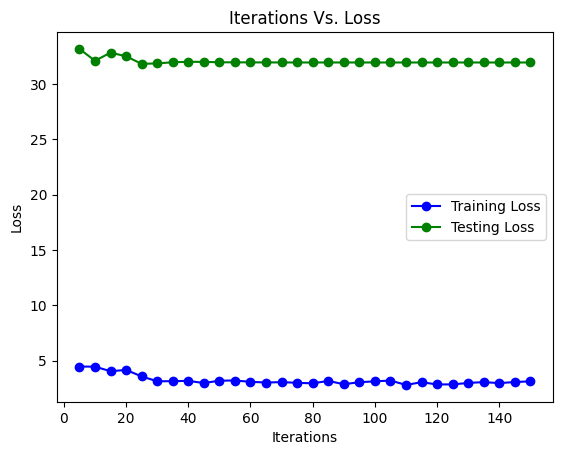

Epoch 29/30 [4/5], Training Batch Loss: 2.699740, Training N-Batch Avg Loss: 3.118249, Testing Avg Loss: 31.96053237915039
End of Epoch 29/30, Average Loss: 2.494599
Number of loss values: 5, Number of batches: 5


In [369]:
%matplotlib inline

# Training loop
for epoch in range(num_epochs):
    model.train()  # set the model to training mode
    total_loss = 0
    loss_count = 0  # Initialize a counter for the number of loss values

    n_batch_loss = 0

    for i, (img1, img2, flow_gt) in enumerate(trainloader): # NOTE: Switch back to 'trainloader'
        img1, img2, flow_gt = img1.to(device), img2.to(device), flow_gt.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        flow_pred = model(img1, img2)

        # Ensure flow_pred is a list
        if not isinstance(flow_pred, list):
            flow_pred = [flow_pred]

        # Compute the loss
        loss = loss_function(flow_pred, flow_gt)  # flow_gt is kept as a tensor
        total_loss += loss.item()
        n_batch_loss += loss.item()
        loss_count += 1  # Increment the loss counter


        # print(endpoint_error(flow_pred, flow_gt))

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        # print(i, log_interval)
        # Print log info
        if (i % log_interval == 0) and (i != 0):

            csv_writer.writerow({'Set': 'train', 'Iteration': (i+1)+(epoch*len(trainloader)), 'Loss': (n_batch_loss / log_interval), 'Accuracy': 0})
            csv_file.flush()

            avg_test_loss = test_evaluation(model, testloader)
            csv_writer.writerow({'Set': 'test', 'Iteration': (i+1)+(epoch*len(trainloader)), 'Loss': avg_test_loss, 'Accuracy': 0})
            csv_file.flush()

            # Plot Data
            plt_x_1.append((i+1)+(epoch*len(trainloader)))
            plt_x_2.append((i+1)+(epoch*len(trainloader)))
            plt_y_1.append(n_batch_loss / log_interval)
            plt_y_2.append(avg_test_loss)

            train_line.set_xdata(plt_x_1)
            train_line.set_ydata(plt_y_1)
            test_line.set_xdata(plt_x_2)
            test_line.set_ydata(plt_y_2)

            ax.relim()
            ax.autoscale_view()
            clear_output(wait=True)
            display(fig)
            plt.pause(0.5)
            # print(i, epoch)
            print(f'Epoch {epoch}/{num_epochs} [{i}/{len(trainloader)}], Training Batch Loss: {loss.item():.6f}, Training N-Batch Avg Loss: {(n_batch_loss / log_interval):.6f}, Testing Avg Loss: {avg_test_loss}') # NOTE: Switch back to 'trainloader'
            n_batch_loss = 0

    # Print epoch info
    avg_loss = total_loss / len(trainloader) # NOTE: Switch back to 'trainloader'
    print(f'End of Epoch {epoch}/{num_epochs}, Average Loss: {avg_loss:.6f}')
    print(f'Number of loss values: {loss_count}, Number of batches: {len(trainloader)}')  # NOTE: Switch back to 'trainloader'# Check the number of loss values
    # Update the learning rate
    scheduler.step()
    # Save model after each epoch

In [370]:
test_evaluation(model, testloader)

31.96053237915039

In [371]:
csv_file.close()
torch.save(model, f'saved_models/model_{timestamp}.pth')

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150] [4.458035469055176, 4.445830464363098, 4.035264074802399, 4.150667369365692, 3.56508868932724, 3.1249329447746277, 3.132505178451538, 3.1631181836128235, 2.9623539447784424, 3.1794341802597046, 3.1948509216308594, 3.0768656730651855, 3.0113205909729004, 3.048588275909424, 2.9856432676315308, 2.9390287697315216, 3.1563804745674133, 2.8592223823070526, 3.0394211411476135, 3.118468940258026, 3.1915325820446014, 2.7948914766311646, 3.0394097566604614, 2.8389599919319153, 2.841909736394882, 2.9727160930633545, 3.050786018371582, 2.9585006833076477, 3.0567355155944824, 3.1182488799095154]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150] [33.18751258850098, 32.1163516998291, 32.84930782318115, 32.523633575439455, 31.83489532470703, 31.87867660522461, 31.98068561553955, 32.02283420562

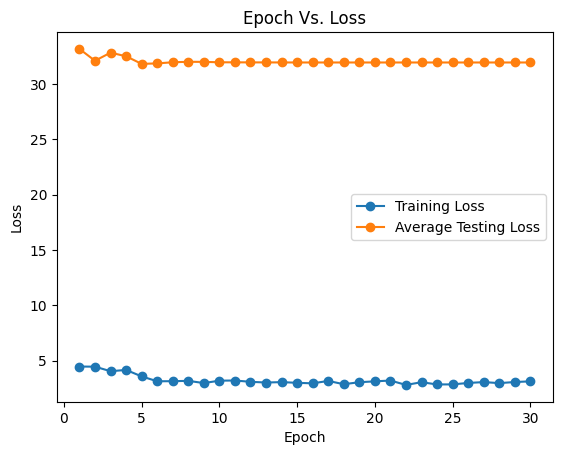

In [372]:

# Create a plot
print(plt_x_1, plt_y_1)
print(plt_x_2, plt_y_2)
plt_x_1_div = [int(num/5) for num in plt_x_1]
plt_x_2_div = [int(num/5) for num in plt_x_2]
print(plt_x_1_div)
plt.plot(plt_x_1_div, plt_y_1, marker='o', label='Training Loss')
plt.plot(plt_x_2_div, plt_y_2, marker='o', label='Average Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Vs. Loss')
plt.legend()

# Save the plot image
plt.savefig(plot_filepath)

# Show the plot (optional)
# plt.show()

In [373]:
# loaded_model = torch.load(f'saved_models/model_{timestamp}.pth')
# print(test_evaluation(loaded_model, testloader))